In [27]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import pmdarima as pma
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm

In [31]:
plt.style.use('ggplot')

In [33]:
years = [
    2023, 2024, 2025, 2026
]

In [35]:
all_years = [
    2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026
]

In [37]:
# data = pd.DataFrame()

# for y in tqdm(years):
#     df = pd.read_csv(f'data/date-hour-soo-dest-{y}.csv').T.reset_index().T
#     data = pd.concat([data, df], axis=0)

# data.head()

In [39]:
full_data = pd.DataFrame()

for y in tqdm(all_years):
    df = pd.read_csv(f'data/date-hour-soo-dest-{y}.csv').T.reset_index().T
    full_data = pd.concat([full_data, df], axis=0)

full_data.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:31<00:00, 10.22s/it]


,0,1,2,3,4
index,2018-01-01,0,12TH,12TH.1,3
0,2018-01-01,0,12TH,16TH,1
1,2018-01-01,0,12TH,BAYF,1
2,2018-01-01,0,12TH,CAST,3
3,2018-01-01,0,12TH,CIVC,2


In [41]:
full_data[0] = pd.to_datetime(full_data[0])

data = full_data[
    full_data[0] >= pd.to_datetime('2023-01-01')
]

In [43]:
data.shape, full_data.shape

((27501648, 5), (68498861, 5))

In [45]:
data = data.rename({
   0: 'date',
   1: 'hour',
    2: 'origin',
    3: 'dest',
    4: 'riders'
}, axis=1)
data.head(1)

,date,hour,origin,dest,riders
index,2023-01-01,0,12TH,12TH.1,1


In [47]:
full_data = full_data.rename({
   0: 'date',
   1: 'hour',
    2: 'origin',
    3: 'dest',
    4: 'riders'
}, axis=1)
full_data.head(1)

,date,hour,origin,dest,riders
index,2018-01-01,0,12TH,12TH.1,3


Station codes in the dictionary below from BART Legacy API website: https://api.bart.gov/docs/overview/abbrev.aspx

In [48]:
station_codes = {
    "12TH": "12th St. Oakland City Center",
    "16TH": "16th St. Mission (SF)",
    "19TH": "19th St. Oakland",
    "24TH": "24th St. Mission (SF)",
    "ASHB": "Ashby (Berkeley)",
    "ANTC": "Antioch",
    "BALB": "Balboa Park (SF)",
    "BAYF": "Bay Fair (San Leandro)",
    "BERY": "Berryessa / North San Jose",
    "CAST": "Castro Valley",
    "CIVC": "Civic Center (SF)",
    "COLS": "Coliseum",
    "COLM": "Colma",
    "CONC": "Concord",
    "DALY": "Daly City",
    "DBRK": "Downtown Berkeley",
    "DUBL": "Dublin/Pleasanton",
    "DELN": "El Cerrito del Norte",
    "PLZA": "El Cerrito Plaza",
    "EMBR": "Embarcadero (SF)",
    "FRMT": "Fremont",
    "FTVL": "Fruitvale (Oakland)",
    "GLEN": "Glen Park (SF)",
    "HAYW": "Hayward",
    "LAFY": "Lafayette",
    "LAKE": "Lake Merritt (Oakland)",
    "MCAR": "MacArthur (Oakland)",
    "MLBR": "Millbrae",
    "MLPT": "Milpitas",
    "MONT": "Montgomery St. (SF)",
    "NBRK": "North Berkeley",
    "NCON": "North Concord/Martinez",
    "OAKL": "Oakland Int'l Airport",
    "ORIN": "Orinda",
    "PITT": "Pittsburg/Bay Point",
    "PCTR": "Pittsburg Center",
    "PHIL": "Pleasant Hill",
    "POWL": "Powell St. (SF)",
    "RICH": "Richmond",
    "ROCK": "Rockridge (Oakland)",
    "SBRN": "San Bruno",
    "SFIA": "San Francisco Int'l Airport",
    "SANL": "San Leandro",
    "SHAY": "South Hayward",
    "SSAN": "South San Francisco",
    "UCTY": "Union City",
    "WARM": "Warm Springs/South Fremont",
    "WCRK": "Walnut Creek",
    "WDUB": "West Dublin",
    "WOAK": "West Oakland"
}

In [50]:
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['hour'].astype(int)
data['riders'] = data['riders'].astype(int)

In [52]:
full_data['hour'] = full_data['hour'].astype(int)
full_data['riders'] = full_data['riders'].astype(int)

In [54]:
data['day_of_wk'] = data['date'].dt.day_name()
data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2023-01-01,0,12TH,12TH.1,1,Sunday
0,2023-01-01,0,12TH,16TH,1,Sunday
1,2023-01-01,0,12TH,19TH,2,Sunday
2,2023-01-01,0,12TH,24TH,3,Sunday
3,2023-01-01,0,12TH,ASHB,2,Sunday


In [56]:
full_data['day_of_wk'] = full_data['date'].dt.day_name()
full_data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2018-01-01,0,12TH,12TH.1,3,Monday
0,2018-01-01,0,12TH,16TH,1,Monday
1,2018-01-01,0,12TH,BAYF,1,Monday
2,2018-01-01,0,12TH,CAST,3,Monday
3,2018-01-01,0,12TH,CIVC,2,Monday


In [58]:
data_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
full_data_wkday = full_data[full_data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

In [59]:
# Get dataframe with average riders for each route per hour, only aggregating weekdays
routes_by_hr_wkday = data_wkday[['hour', 'origin', 'dest', 'riders']].groupby(['hour', 'origin', 'dest']).agg('mean')
routes_by_hr_wkday.shape

(54155, 1)

In [60]:
routes_by_hr_wkday = routes_by_hr_wkday.reset_index()
routes_by_hr_wkday.head()

,hour,origin,dest,riders
0,0,12TH,12TH,2.002674
1,0,12TH,12TH.1,2.500000
2,0,12TH,16TH,1.371795
3,0,12TH,19TH,1.089286
4,0,12TH,24TH,1.377778


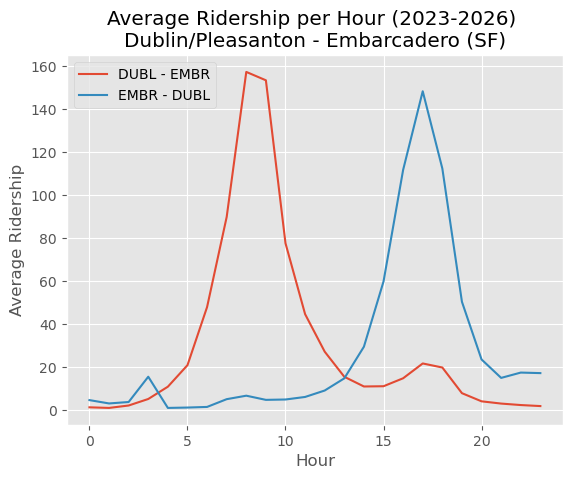

In [61]:
## Average ridership per hour for a specific route

station_1_lower = "dubl"
station_2_lower = "embr"

station_1 = station_1_lower.upper()
station_2 = station_2_lower.upper()

station_1_fullname = station_codes[station_1]
station_2_fullname = station_codes[station_2]

plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['riders'],
    label = f'{station_1} - {station_2}'
)
plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['riders'],
    label = f'{station_2} - {station_1}'
)
plt.xlabel('Hour')
plt.ylabel('Average Ridership')
plt.title(f'Average Ridership per Hour (2023-2026) \n{station_1_fullname} - {station_2_fullname}')
plt.legend();

In [62]:
exits_by_hr = data[['date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
).agg('mean').reset_index()
exits_by_hr.head()

,hour,dest,date,riders
0,0,12TH,2024-07-17 12:30:41.563055104,30.334813
1,0,12TH.1,2024-05-02 00:00:00.000000000,2.000000
2,0,16TH,2024-07-17 13:31:54.893616896,30.975177
3,0,19TH,2024-07-17 12:30:41.563055104,31.849911
4,0,24TH,2024-07-17 13:31:54.893616896,33.498227


In [63]:
exits_by_hr.shape

(1201, 4)

In [64]:
exits_by_hr_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])][[
 'date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
 ).agg('mean').reset_index()
exits_by_hr_wkday.head()

,hour,dest,date,riders
0,0,12TH,2024-07-17 16:49:25.756823808,24.199752
1,0,12TH.1,2024-12-31 12:00:00.000000000,2.500000
2,0,16TH,2024-07-17 16:49:25.756823808,22.986352
3,0,19TH,2024-07-17 16:49:25.756823808,23.564516
4,0,24TH,2024-07-17 16:49:25.756823808,25.548387


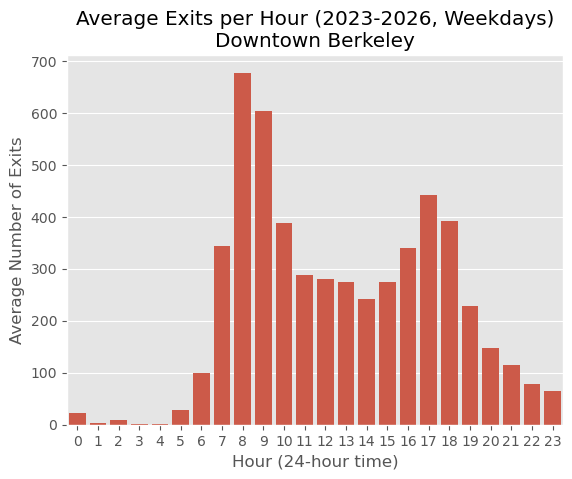

In [65]:
station_lower = 'dbrk'
station = station_lower.upper()
station_fullname = station_codes[station]

sns.barplot(
    data = exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station],
    x = 'hour',
    y = 'riders'
)
plt.xlabel('Hour (24-hour time)')
plt.ylabel('Average Number of Exits')
plt.title(f'Average Exits per Hour (2023-2026, Weekdays)\n{station_fullname}');

In [66]:
np.sum(exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station]['riders'])

np.float64(5340.773854509913)

## Arrivals/Departures & Land Use

As described in the [BART Ridership snapshot for April 2025](https://www.bart.gov/sites/default/files/2025-05/202504%20Monthly%20Ridership%20Snapshot.pdf), the arrivals/departures ratio during AM commute times can be useful as a proxy for land use. Stations with more departures are likely to have more residential land use (housing-focused), whereas stations with more arrivals are likely to have more commerical, industrial, and office land use (jobs-focused). Those with a balance between arrivals and departures during AM commute times have more balanced land use. Note that this is a general proxy and may not be applicable in certain cases, i.e. arrivals/departures from SF and Oakland Int'l airports.

The ridership snapshot provides a handy chart for this, but it is limited in readability. We can visualize and analyze arrival/departure ratio with hourly ridership data.

In [67]:
# Filter for AM commute times on weekdays
am_commutes = data[
    (data['hour'] >= 4) & (data['hour'] <= 11) & (~data['day_of_wk'].isin(['Sunday', 'Saturday']))
]
am_commutes.head()

,date,hour,origin,dest,riders,day_of_wk
16218,2023-01-02,4,12TH,12TH,2,Monday
16219,2023-01-02,4,ANTC,ANTC,1,Monday
16220,2023-01-02,4,ANTC,PCTR,1,Monday
16221,2023-01-02,4,BALB,BALB,2,Monday
16222,2023-01-02,4,CIVC,CIVC,1,Monday


In [68]:
am_commutes.shape

(7436725, 6)

In [69]:
departures_am = am_commutes.groupby(['origin']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'departures'}, axis=1)
exits_am = am_commutes.groupby(['dest']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'arrivals'}, axis=1)
departures_am.head()

,origin,departures
0,12TH,1277497
1,16TH,1179207
2,19TH,1401658
3,24TH,1759793
4,ANTC,1108274


In [70]:
exits_am.head()

,dest,arrivals
0,12TH,1940464
1,16TH,1777548
2,19TH,1484232
3,24TH,1249894
4,ANTC,116858


In [71]:
deps_arrs = pd.merge(left=departures_am, right=exits_am, left_on='origin', right_on='dest').drop(['dest'], axis=1).rename(
    {
        'origin': 'station_code'
    }, axis=1
)
deps_arrs['station_name'] = deps_arrs['station_code'].map(lambda x: station_codes[x])
deps_arrs['arr_dep_ratio'] = deps_arrs['arrivals'] / deps_arrs['departures']
deps_arrs['arr_pct'] = deps_arrs['arrivals'] / (deps_arrs['arrivals'] + deps_arrs['departures']) * 100
deps_arrs = deps_arrs[['station_code', 'station_name', 'departures', 'arrivals', 'arr_dep_ratio', 'arr_pct']]
deps_arrs.head()

,station_code,station_name,departures,arrivals,arr_dep_ratio,arr_pct
0,12TH,12th St. Oakland City Center,1277497,1940464,1.518958,60.301042
1,16TH,16th St. Mission (SF),1179207,1777548,1.507410,60.118204
2,19TH,19th St. Oakland,1401658,1484232,1.058912,51.430651
3,24TH,24th St. Mission (SF),1759793,1249894,0.710251,41.529036
4,ANTC,Antioch,1108274,116858,0.105441,9.538401


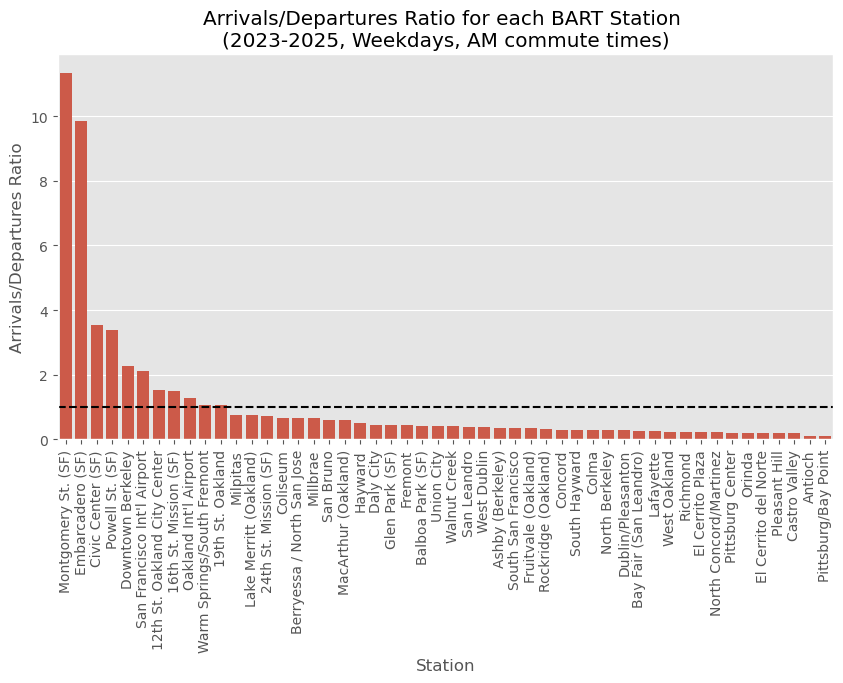

In [72]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = deps_arrs.sort_values(['arr_dep_ratio'], ascending=False),
    x = 'station_name',
    y = 'arr_dep_ratio'
)
plt.xlabel('Station')
plt.ylabel('Arrivals/Departures Ratio')
plt.title('Arrivals/Departures Ratio for each BART Station \n(2023-2025, Weekdays, AM commute times)')
plt.xticks(rotation=90)
plt.axhline(y = 1, color='black', linestyle = '--');

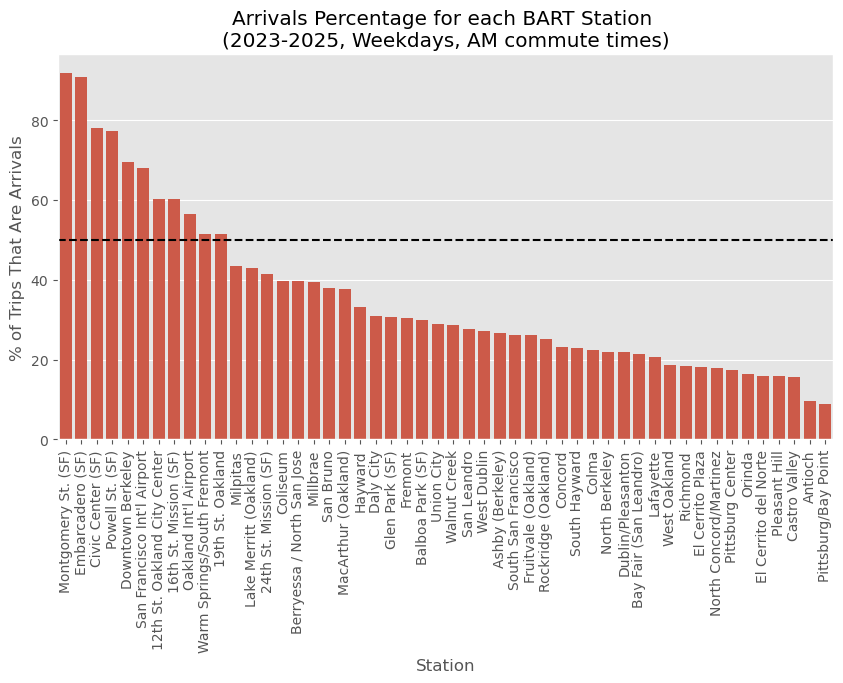

In [73]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = deps_arrs.sort_values(['arr_pct'], ascending=False),
    x = 'station_name',
    y = 'arr_pct'
)
plt.xlabel('Station')
plt.ylabel('% of Trips That Are Arrivals')
plt.title('Arrivals Percentage for each BART Station \n(2023-2025, Weekdays, AM commute times)')
plt.xticks(rotation=90)
plt.axhline(y = 50, color='black', linestyle = '--');

## Where From?

[Hundreds of thousands](https://www.bart.gov/news/articles/2025/news20250109-1) of people use BART everyday. Many stations - both city center and suburban - have average weekday riderships in the thousands. So we can ask, given a specific station $X$, where are people who exit at $X$ departing from _on the average day_?

In [74]:
exit_stat_lower = 'dbrk'
exit_stat = exit_stat_lower.upper()
exit_stat_fullname = station_codes[exit_stat]

In [75]:
exits_at_stat = data_wkday[data_wkday['dest'] == exit_stat].groupby(['date', 'origin']).agg({'riders': 'sum'})
exits_at_stat = exits_at_stat.reset_index().groupby(['origin']).agg({'riders': 'mean'}).reset_index().sort_values(by=['riders'], ascending=False)
exits_at_stat['origin_fullname'] = exits_at_stat['origin'].map(lambda x: station_codes[x])
exits_at_stat = exits_at_stat[['origin', 'origin_fullname', 'riders']]
exits_at_stat.head()

,origin,origin_fullname,riders
18,EMBR,Embarcadero (SF),436.744417
16,DELN,El Cerrito del Norte,411.635236
37,POWL,Powell St. (SF),325.785360
28,MONT,Montgomery St. (SF),319.844913
36,PLZA,El Cerrito Plaza,310.717122


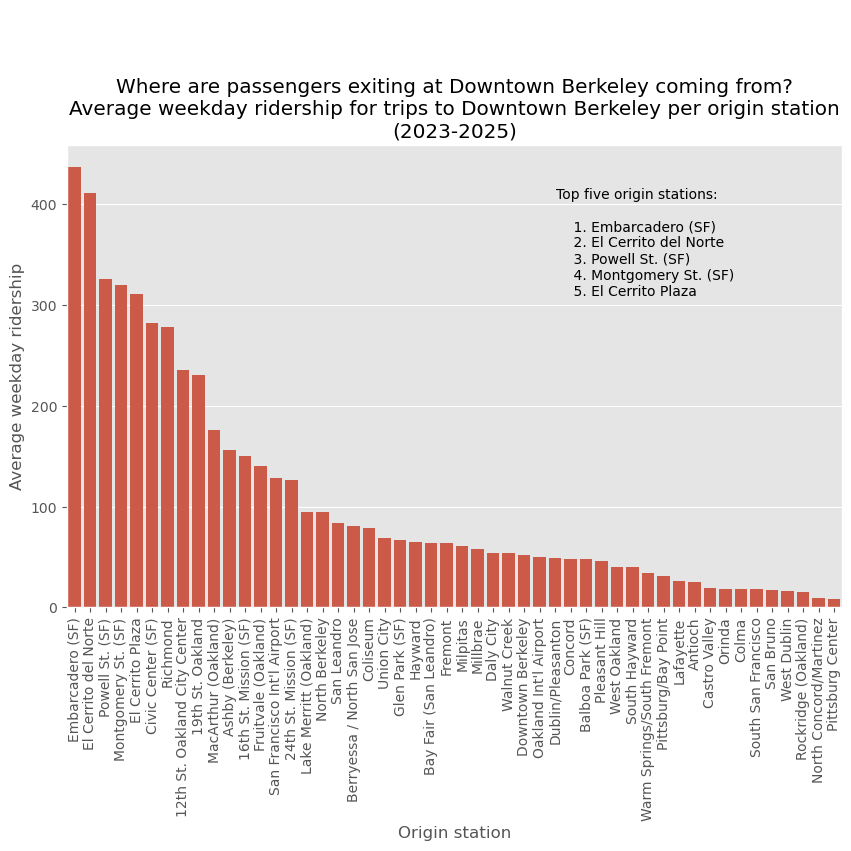

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data = exits_at_stat,
    x = 'origin_fullname',
    y = 'riders'
)

plt.xlabel('Origin station')
plt.ylabel('Average weekday ridership')
plt.title(f'''Where are passengers exiting at {exit_stat_fullname} coming from?
Average weekday ridership for trips to {exit_stat_fullname} per origin station\n(2023-2025)''')
plt.annotate(
    text = f'''Top five origin stations:\n
    1. {exits_at_stat.iloc[0, 1]}
    2. {exits_at_stat.iloc[1, 1]}
    3. {exits_at_stat.iloc[2, 1]}
    4. {exits_at_stat.iloc[3, 1]}
    5. {exits_at_stat.iloc[4, 1]}''',
    xycoords = 'figure points',
    xy = (400, 400),
    xytext = (400, 400)
)
plt.xticks(rotation=90);

We can narrow this down to AM commute times to get a picture of who is commuting from where to station $X$ for work or school.

In [77]:
exits_at_stat_am = data_wkday[
    (data_wkday['dest'] == exit_stat) & (data_wkday['hour'] >= 4) & (data_wkday['hour'] <= 11)
    ].groupby(['date', 'origin']).agg({'riders': 'sum'})
exits_at_stat_am = exits_at_stat_am.reset_index().groupby(['origin']).agg({'riders': 'mean'}).reset_index().sort_values(by=['riders'], ascending=False)
exits_at_stat_am['origin_fullname'] = exits_at_stat_am['origin'].map(lambda x: station_codes[x])
exits_at_stat_am = exits_at_stat_am[['origin', 'origin_fullname', 'riders']]
exits_at_stat_am.head()

,origin,origin_fullname,riders
16,DELN,El Cerrito del Norte,287.883375
36,PLZA,El Cerrito Plaza,189.418114
38,RICH,Richmond,180.357764
2,19TH,19th St. Oakland,100.424845
0,12TH,12th St. Oakland City Center,99.028536


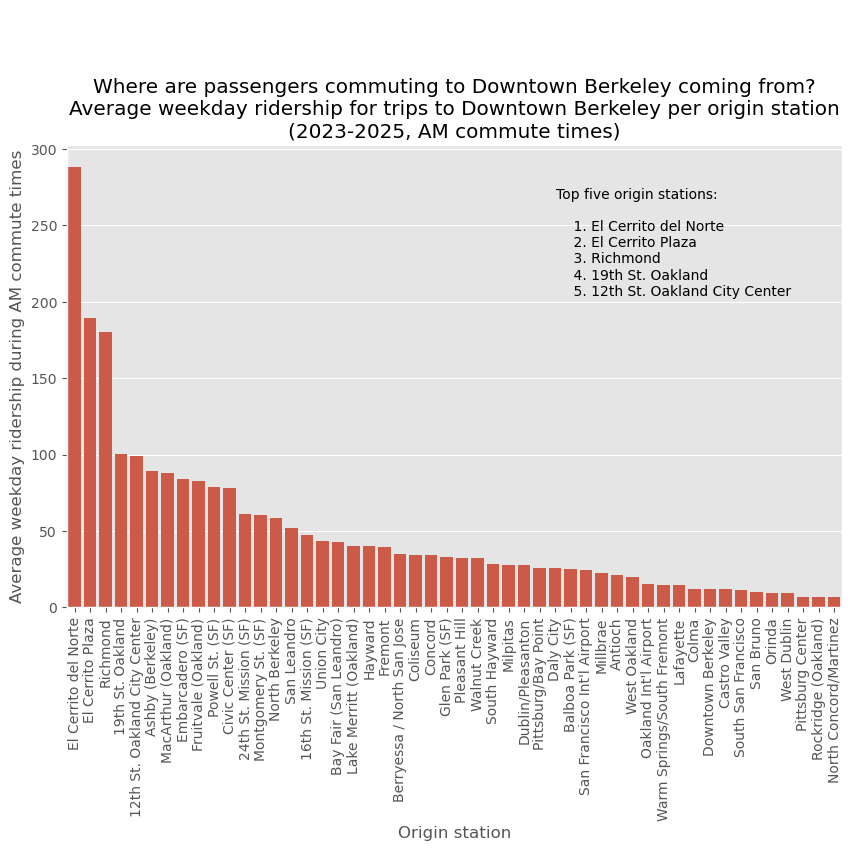

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data = exits_at_stat_am,
    x = 'origin_fullname',
    y = 'riders'
)

plt.xlabel('Origin station')
plt.ylabel('Average weekday ridership during AM commute times')
plt.title(f'''Where are passengers commuting to {exit_stat_fullname} coming from?
Average weekday ridership for trips to {exit_stat_fullname} per origin station\n(2023-2025, AM commute times)''')
plt.annotate(
    text = f'''Top five origin stations:\n
    1. {exits_at_stat_am.iloc[0, 1]}
    2. {exits_at_stat_am.iloc[1, 1]}
    3. {exits_at_stat_am.iloc[2, 1]}
    4. {exits_at_stat_am.iloc[3, 1]}
    5. {exits_at_stat_am.iloc[4, 1]}''',
    xycoords = 'figure points',
    xy = (400, 400),
    xytext = (400, 400)
)
plt.xticks(rotation=90);

## Ridership Patterns & Trends

The pandemic and the rise of remote work has caused ridership on public transit networks around the country, including BART, to drop - many still haven't recovered. How well has the recovery been going?

In [79]:
# full_data['date'] = pd.to_datetime(full_data['date'])

In [80]:
daily_riders_full = full_data.groupby(['date']).agg({'riders': 'sum'})# |.reset_index()
daily_riders_full.head()

,riders
date,
2018-01-01,110254
2018-01-02,332343
2018-01-03,361718
2018-01-04,369714
2018-01-05,347483


In [81]:
n = 14
moving_avg_riders = daily_riders_full.rolling(n).mean()[n-1:].reset_index()
daily_riders_full = daily_riders_full.reset_index()
moving_avg_riders.head()

,date,riders
0,2018-01-14,285906.000000
1,2018-01-15,291002.428571
2,2018-01-16,296694.714286
3,2018-01-17,300493.071429
4,2018-01-18,303478.142857


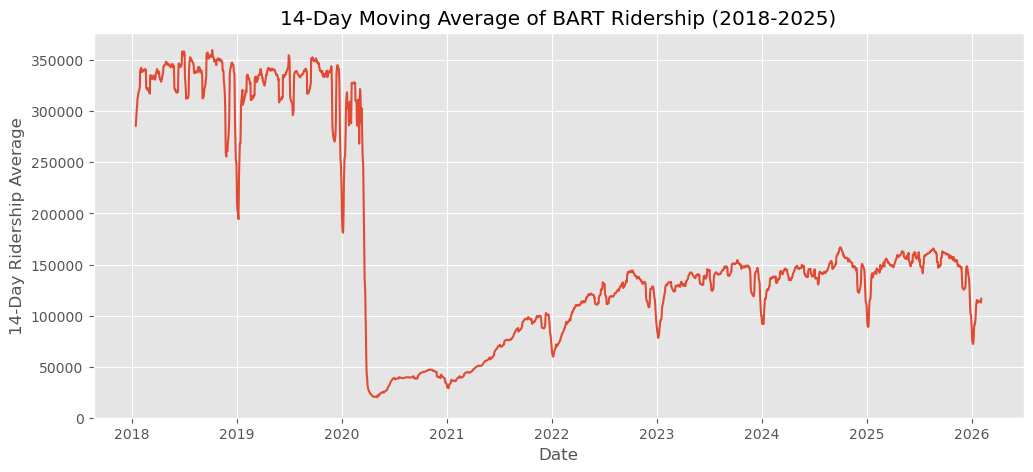

In [82]:
plt.figure(figsize=(12, 5))
plt.plot(moving_avg_riders['date'], moving_avg_riders['riders'])
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Average')
plt.title('14-Day Moving Average of BART Ridership (2018-2025)')
plt.ylim(bottom=0);

In [83]:
pre_covid_data = full_data[
    (full_data['date'] <= pd.to_datetime('2020-02-01'))
]
pre_covid_data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2018-01-01,0,12TH,12TH.1,3,Monday
0,2018-01-01,0,12TH,16TH,1,Monday
1,2018-01-01,0,12TH,BAYF,1,Monday
2,2018-01-01,0,12TH,CAST,3,Monday
3,2018-01-01,0,12TH,CIVC,2,Monday


In [84]:
pre_covid_data.shape

(21169703, 6)

In [85]:
post_covid_data = full_data[
    (full_data['date'] >= pd.to_datetime('2021-11-01'))
]
post_covid_data.head()

,date,hour,origin,dest,riders,day_of_wk
5334271,2021-11-01,0,12TH,24TH,2,Monday
5334272,2021-11-01,0,12TH,ASHB,1,Monday
5334273,2021-11-01,0,12TH,DALY,2,Monday
5334274,2021-11-01,0,12TH,FRMT,1,Monday
5334275,2021-11-01,0,12TH,MLPT,2,Monday


In [86]:
### How has ridership held up by station?

pre_covid_stations = pre_covid_data.groupby(['dest', 'date']).agg({'riders': 'sum'}).groupby(['dest']).agg({'riders': 'mean'}).reset_index()
pre_covid_stations.head()

,dest,riders
0,12TH,10630.118265
1,12TH.1,3.000000
2,16TH,10365.231275
3,19TH,10400.091984
4,24TH,9932.542707


In [87]:
post_covid_stations = post_covid_data.groupby(['dest', 'date']).agg({'riders': 'sum'}).groupby(['dest']).agg({'riders': 'mean'}).reset_index()
post_covid_stations.head()

,dest,riders
0,12TH,3755.653376
1,12TH.1,1.750000
2,16TH,4661.489389
3,19TH,3608.948553
4,24TH,4476.787781


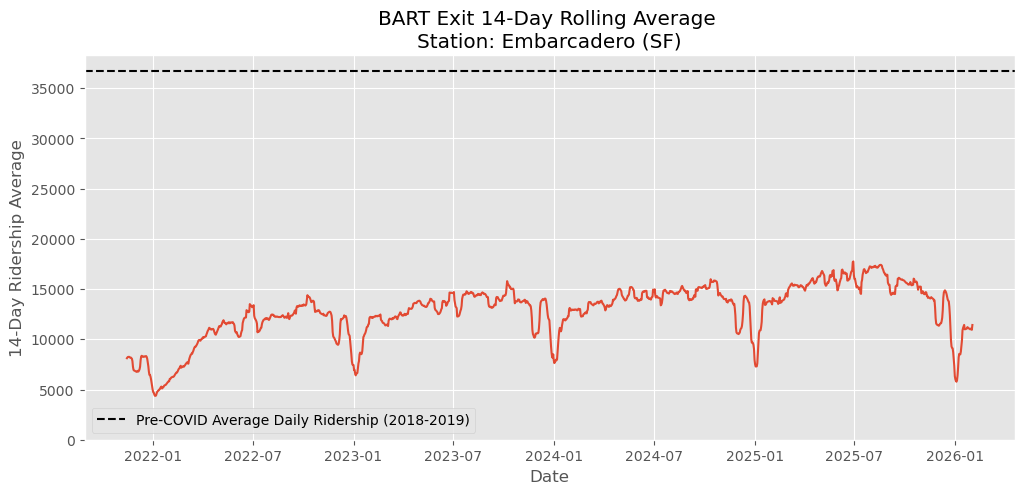

In [92]:
## Edit this to change station
station_lower = "embr"

##################################
station = station_lower.upper()
station_fullname = station_codes[station]

## All days
pre_cov_stat = pre_covid_data[
    (pre_covid_data['dest'] == station) # & (~pre_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'}).reset_index()
post_cov_stat = post_covid_data[
    (post_covid_data['dest'] == station) # & (~post_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'})# .reset_index()

pre_cov_daily_avg = np.mean(pre_cov_stat['riders'])

post_cov_rolling = post_cov_stat.rolling(14).mean().reset_index()[6:]

plt.figure(figsize=(12, 5))
plt.plot(
    post_cov_rolling['date'],
    post_cov_rolling['riders']
)
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Average')
plt.title(f'BART Exit 14-Day Rolling Average \nStation: {station_fullname}')
plt.axhline(y = pre_cov_daily_avg, label='Pre-COVID Average Daily Ridership (2018-2019)', color = 'black', linestyle = '--')
plt.ylim(bottom=0)
plt.legend();

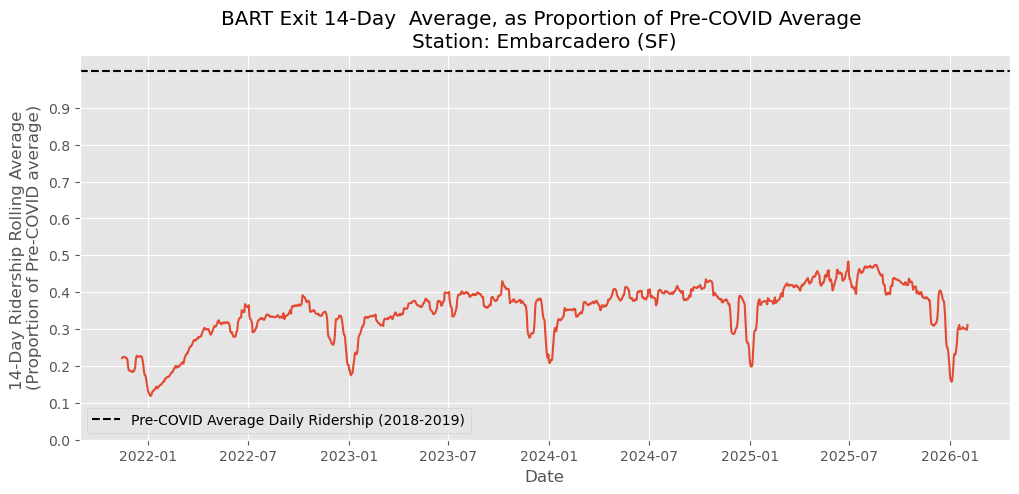

In [93]:
## Same as above, but as a proportion/fraction of pre-COVID average

## All days
pre_cov_stat = pre_covid_data[
    (pre_covid_data['dest'] == station) # & (~pre_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'}).reset_index()
post_cov_stat = post_covid_data[
    (post_covid_data['dest'] == station) # & (~post_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'})# .reset_index()

pre_cov_daily_avg = np.mean(pre_cov_stat['riders'])

post_cov_rolling = post_cov_stat.rolling(14).mean().reset_index()[6:]
post_cov_rolling['riders'] = post_cov_rolling['riders'] / pre_cov_daily_avg

plt.figure(figsize=(12, 5))
plt.plot(
    post_cov_rolling['date'],
    post_cov_rolling['riders']
)
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Rolling Average \n(Proportion of Pre-COVID average)')
plt.title(f'BART Exit 14-Day  Average, as Proportion of Pre-COVID Average \nStation: {station_fullname}')
plt.axhline(y = 1, label='Pre-COVID Average Daily Ridership (2018-2019)', color = 'black', linestyle = '--')
plt.ylim(bottom=0)
plt.yticks(ticks=np.arange(start=0, stop=1, step=0.1))
plt.legend();

## Projecting Future Ridership Trends
In which we use SARIMA and Prophet to project future ridership trends.

In [94]:
daily_riders_full['month'] = daily_riders_full['date'].dt.month_name()
daily_riders_full['year'] = daily_riders_full['date'].map(lambda x: x.year)
daily_riders_full['day_of_wk'] = daily_riders_full['date'].dt.day_name()
daily_riders_full.head()

,date,riders,month,year,day_of_wk
0,2018-01-01,110254,January,2018,Monday
1,2018-01-02,332343,January,2018,Tuesday
2,2018-01-03,361718,January,2018,Wednesday
3,2018-01-04,369714,January,2018,Thursday
4,2018-01-05,347483,January,2018,Friday


In [95]:
daily_riders_full[-7:]

,date,riders,month,year,day_of_wk
2944,2026-01-27,147003,January,2026,Tuesday
2945,2026-01-28,146962,January,2026,Wednesday
2946,2026-01-29,146349,January,2026,Thursday
2947,2026-01-30,120217,January,2026,Friday
2948,2026-01-31,74426,January,2026,Saturday
2949,2026-02-01,52976,February,2026,Sunday
2950,2026-02-02,121264,February,2026,Monday


In [98]:
## Differencing, weekdays only
daily_riders_full['riders'] = daily_riders_full['riders'].astype(int)
daily_diff = daily_riders_full.set_index(['date', 'month', 'year', 'day_of_wk']).diff().reset_index()
daily_diff.head()

,date,month,year,day_of_wk,riders
0,2018-01-01,January,2018,Monday,NaN
1,2018-01-02,January,2018,Tuesday,222089.0
2,2018-01-03,January,2018,Wednesday,29375.0
3,2018-01-04,January,2018,Thursday,7996.0
4,2018-01-05,January,2018,Friday,-22231.0


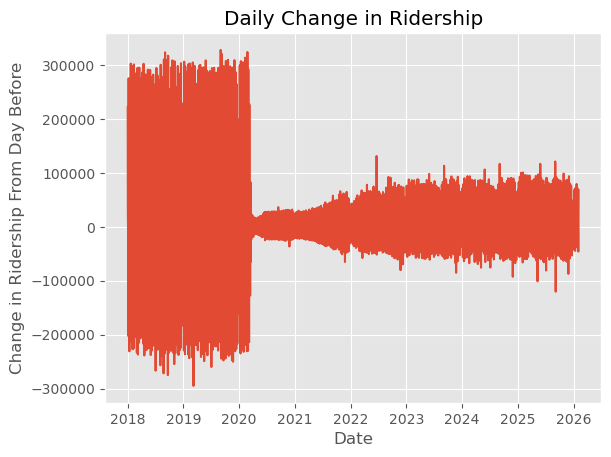

In [99]:
plt.plot(
    daily_diff['date'],
    daily_diff['riders']
)
plt.xlabel('Date')
plt.ylabel('Change in Ridership From Day Before')
plt.title('Daily Change in Ridership');

In [100]:
## Monthly ridership & change
monthly_riders_full = daily_riders_full[~daily_riders_full['day_of_wk'].isin(['Sunday', 'Saturday'])].groupby(['month', 'year']).agg({'riders': 'mean'}).reset_index()
monthly_riders_full.head()

,month,year,riders
0,April,2018,415635.809524
1,April,2019,417408.636364
2,April,2020,25848.190476
3,April,2021,58950.045455
4,April,2022,133737.095238


In [101]:
monthly_riders_full.shape

(98, 3)

In [102]:
monthly_riders_full['date'] = pd.to_datetime(monthly_riders_full["month"] + " " + monthly_riders_full["year"].astype(str))
monthly_riders_full = monthly_riders_full.sort_values(by=['date'])
monthly_riders_full.head()

,month,year,riders,date
33,January,2018,376024.000000,2018-01-01
24,February,2018,404399.950000,2018-02-01
58,March,2018,411693.909091,2018-03-01
0,April,2018,415635.809524,2018-04-01
66,May,2018,406370.043478,2018-05-01


In [105]:
daily_riders_full.sort_values(by=['date'], ascending=False).head()

,date,riders,month,year,day_of_wk
2950,2026-02-02,121264,February,2026,Monday
2949,2026-02-01,52976,February,2026,Sunday
2948,2026-01-31,74426,January,2026,Saturday
2947,2026-01-30,120217,January,2026,Friday
2946,2026-01-29,146349,January,2026,Thursday


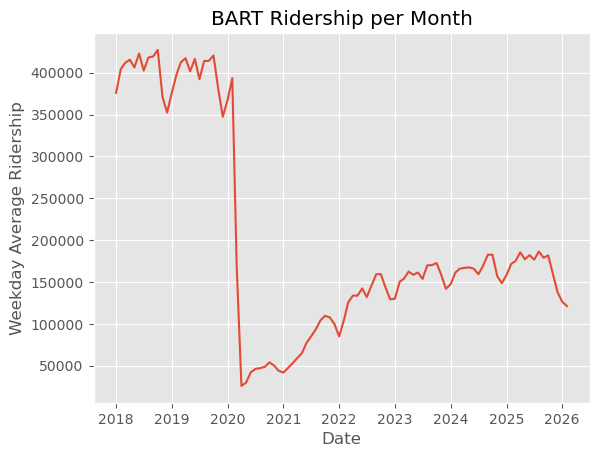

In [103]:
plt.plot(
    monthly_riders_full['date'],
    monthly_riders_full['riders']
)
plt.xlabel('Date')
plt.ylabel('Weekday Average Ridership')
plt.title('BART Ridership per Month');

In [106]:
monthly_riders = pd.DataFrame(monthly_riders_full[monthly_riders_full['year']>2020][:-1].set_index(['date'])['riders'])
monthly_riders.head()

,riders
date,
2021-01-01,41721.047619
2021-02-01,47508.500000
2021-03-01,52676.347826
2021-04-01,58950.045455
2021-05-01,64608.285714


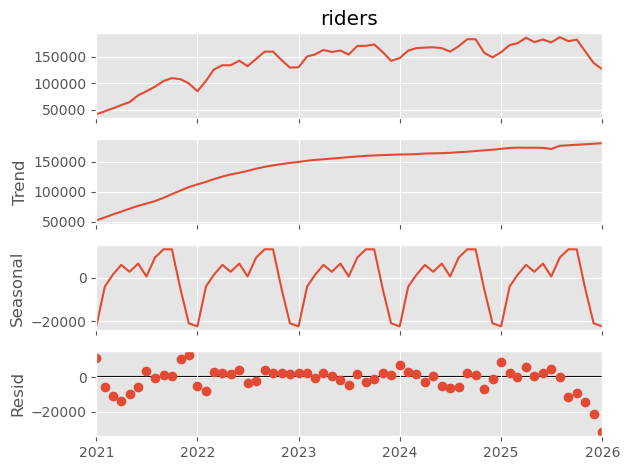

In [107]:
## Decompose into components: trend, seasonality, residuals/error

decompose = seasonal_decompose(monthly_riders['riders'], model='additive', extrapolate_trend='freq', period=12)

decompose.plot().show()

In [108]:
monthly_change = pd.DataFrame(monthly_riders_full.set_index(['date'])[:-1]['riders'].diff())[1:]
monthly_change.head()

,riders
date,
2018-02-01,28375.950000
2018-03-01,7293.959091
2018-04-01,3941.900433
2018-05-01,-9265.766046
2018-06-01,16655.813665


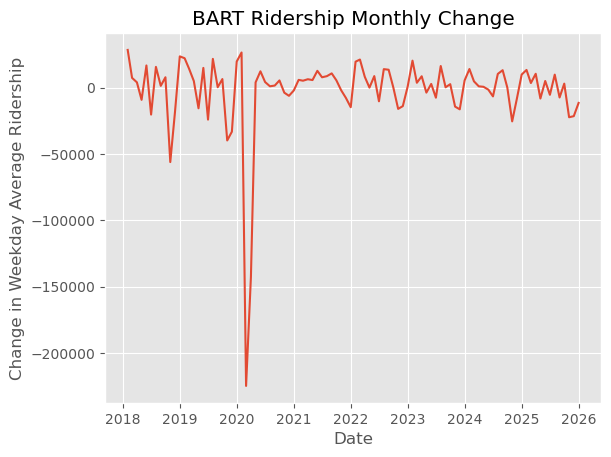

In [109]:
plt.plot(
    monthly_change['riders']
)
plt.xlabel('Date')
plt.ylabel('Change in Weekday Average Ridership')
plt.title('BART Ridership Monthly Change');

In [110]:
second_order_change = monthly_change = pd.DataFrame(monthly_riders_full.set_index(['date'])[:-1]['riders'].diff().diff())[2:]
second_order_change.head()

,riders
date,
2018-03-01,-21081.990909
2018-04-01,-3352.058658
2018-05-01,-13207.666478
2018-06-01,25921.579710
2018-07-01,-37023.852626


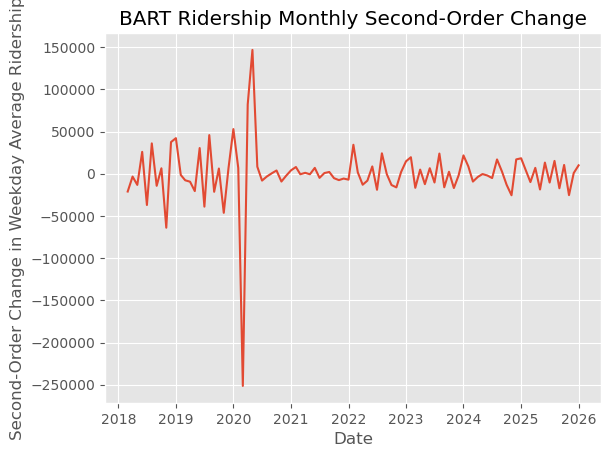

In [111]:
plt.plot(
    second_order_change['riders']
)
plt.xlabel('Date')
plt.ylabel('Second-Order Change in Weekday Average Ridership')
plt.title('BART Ridership Monthly Second-Order Change');

In [112]:
## ADF Test (Augmented Dicky-Fuller)
adf_test = adfuller(second_order_change[second_order_change.index >= pd.to_datetime('2021-01-01')]['riders'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p = {adf_test[1]}')
print("p < 0.05, stationary" if (adf_test[1] < 0.05 and adf_test[0] < 0) else "p > 0.05, not stationary")

ADF Statistic: -4.8636197527351355
p = 4.102990295952168e-05
p < 0.05, stationary


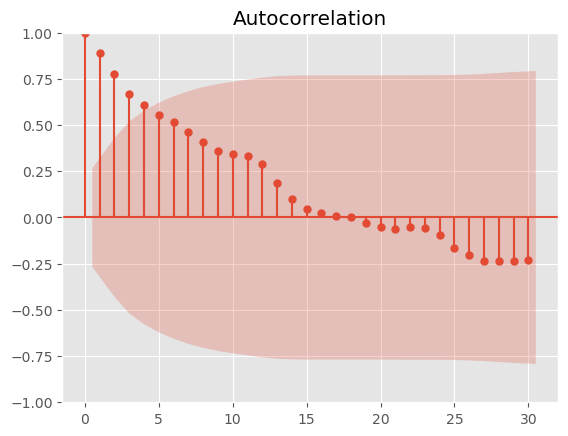

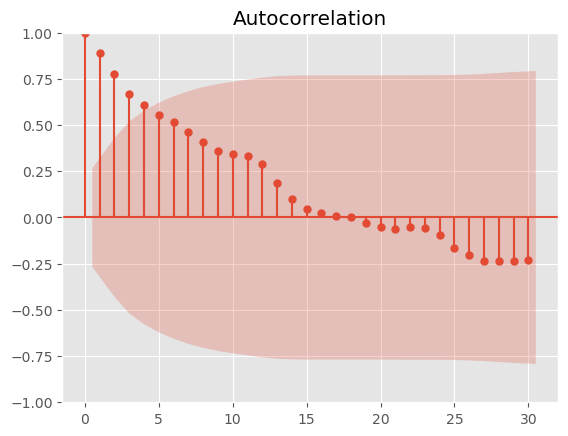

In [120]:
## ACF and PACF
plot_acf(monthly_riders[monthly_riders.index < pd.to_datetime('2025-07-01')]['riders'], lags=30)

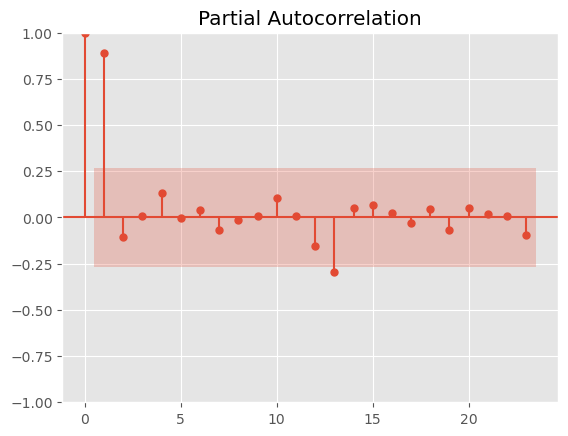

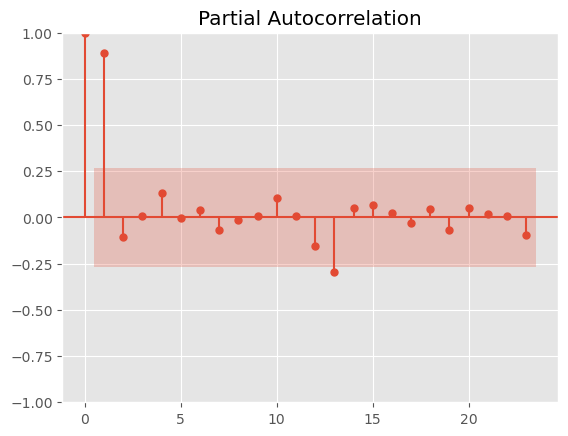

In [122]:
## ACF and PACF
plot_pacf(monthly_riders[monthly_riders.index < pd.to_datetime('2025-07-01')]['riders'], lags=23)

In [140]:
## PMDARIMA

len_dat = monthly_riders['riders'].shape[0]
train, test = train_test_split(monthly_riders['riders'], train_size = len_dat - 4)
# train, test

In [141]:
len_dat

61

In [142]:
model = pma.auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, start_q=2, max_p=20, max_q=20, d=2, error_action='warn', m=12)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   57
Model:             SARIMAX(0, 2, 1)x(2, 0, [], 12)   Log Likelihood                -581.062
Date:                             Sat, 14 Feb 2026   AIC                           1170.124
Time:                                     01:19:02   BIC                           1178.154
Sample:                                 01-01-2021   HQIC                          1173.229
                                      - 09-01-2025                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9314      0.037    -25.049      0.000      -1.004      -0.858
ar.S.L12       0.2044      0.049      4.160      0.000       0.108       0.301
ar.S.L24       0.3904      0.117      3.329      0.001       0.161       0.620
sigma2      7.922e+07   2.79e-10   2.84e+17      0.000    7.92e+07    7.92e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.26
Prob(Q):                              0.75   Prob(JB):                         0.20
Heteroskedasticity (H):               0.34   Skew:                            -0.40
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+33. Standard errors may be unstable.
"""

In [143]:
predicted_test, pred_conf_int = model.predict(n_periods = test.shape[0], return_conf_int=True)

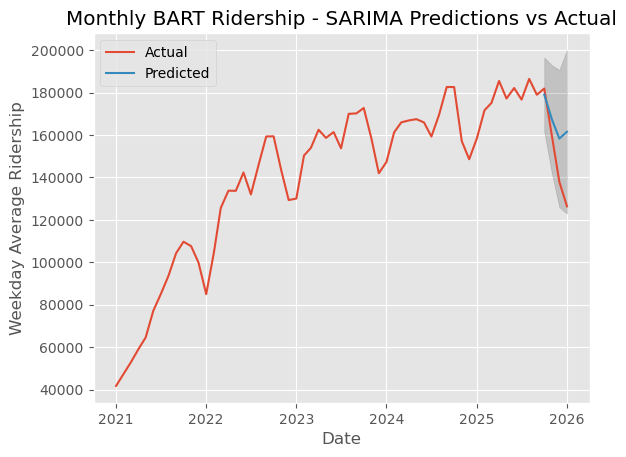

In [144]:
plt.plot(
    monthly_riders['riders'],
    label = 'Actual'
)
plt.plot(
    predicted_test,
    label = 'Predicted'
)
plt.fill_between(
    test.index,
    pred_conf_int[:, 0],
    pred_conf_int[:, 1],
    color='k', alpha=0.15
)
plt.xlabel('Date')
plt.ylabel('Weekday Average Ridership')
plt.title('Monthly BART Ridership - SARIMA Predictions vs Actual')
plt.legend();

In [145]:
# How well does our model do?
mse = mean_squared_error(test, predicted_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, predicted_test)
print(f'RMSE = {rmse},\nMAPE = {mape}')

RMSE = 20728.34652520845,
MAPE = 0.12258597206317673


In [148]:
# Now, predict BART ridership to 2027
# SARIMAX model - order = (2, 2, 2), seasonal_order = (0, 1, 1, 12)
modelfit = model.fit(monthly_riders['riders'])
pred, ci = modelfit.predict(n_periods = 12, return_conf_int = True)

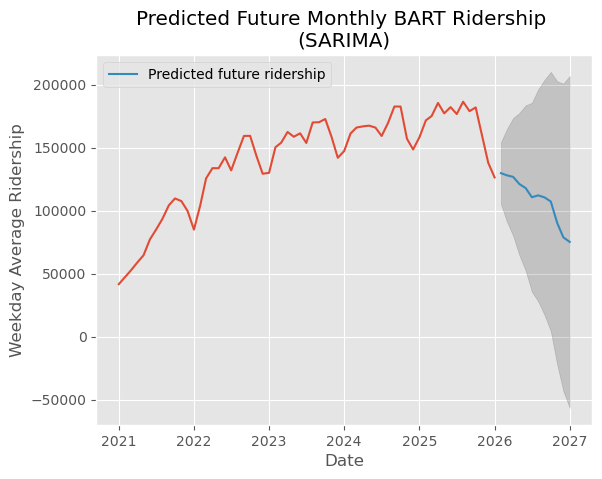

In [149]:
plt.plot(
    monthly_riders['riders'],
)
plt.plot(
    pred, label='Predicted future ridership'
)
plt.fill_between(
    pred.index,
    ci[:, 0],
    ci[:, 1],
    color='k', alpha=0.15
)
plt.xlabel('Date')
plt.ylabel('Weekday Average Ridership')
plt.title('Predicted Future Monthly BART Ridership \n(SARIMA)')
plt.legend();

In [150]:
# Limitations: Doesn't take into account potentially useful exogenous factors
# Possible improvements: exogenous factors, perhaps BSTS hierarchal to include station-level trends?

In [151]:
## Now try out Prophet - different forecasting technique for time series
## (basic model)

mrid = monthly_riders.copy()
mrid = mrid.reset_index().rename({
    'date': 'ds',
    'riders': 'y'
}, axis=1)
mrid.head()

,ds,y
0,2021-01-01,41721.047619
1,2021-02-01,47508.500000
2,2021-03-01,52676.347826
3,2021-04-01,58950.045455
4,2021-05-01,64608.285714


In [167]:
n = 16

In [168]:
train, test = train_test_split(mrid.set_index(['ds'])['y'], train_size = len_dat - n)

In [169]:
model_prophet = Prophet(interval_width=0.95, seasonality_mode='additive')
model_prophet.fit(pd.DataFrame(train).reset_index())

01:26:53 - cmdstanpy - INFO - Chain [1] start processing
01:26:53 - cmdstanpy - INFO - Chain [1] done processing


In [170]:
df_cv = cross_validation(model_prophet, initial='730 days', period='120 days', horizon='30 days')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/5 [00:00<?, ?it/s]

01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:56 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:56 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:57 - cmdstanpy - INFO - Chain [1] done processing
01:26:57 - cmdstanpy - INFO - Chain [1] start processing
01:26:58 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,2.123054e+07,4607.661168,4607.661168,0.029044,0.029044,0.028629,1.0
1,24 days,7.131350e+08,26704.587969,26704.587969,0.156924,0.156924,0.145507,0.0
2,26 days,1.489103e+08,12202.882607,12202.882607,0.082846,0.082846,0.086426,0.0
3,27 days,1.024379e+07,3200.592345,3200.592345,0.019112,0.019112,0.018931,1.0
4,30 days,2.057428e+06,1434.373612,1434.373612,0.007854,0.007854,0.007885,1.0


In [171]:
df_pred = model_prophet.make_future_dataframe(periods=n, freq='MS')
df_pred.shape

(61, 1)

In [172]:
forecast_prophet = model_prophet.predict(df_pred)
forecast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,52545.123624,25690.666640,41254.031630,52545.123624,52545.123624,-18729.094687,-18729.094687,-18729.094687,-18729.094687,-18729.094687,-18729.094687,0.0,0.0,0.0,33816.028937
1,2021-02-01,57689.396132,37850.529186,53032.803727,57689.396132,57689.396132,-12124.947078,-12124.947078,-12124.947078,-12124.947078,-12124.947078,-12124.947078,0.0,0.0,0.0,45564.449054
2,2021-03-01,62335.835840,53056.642174,69066.780334,62335.835840,62335.835840,-1461.033384,-1461.033384,-1461.033384,-1461.033384,-1461.033384,-1461.033384,0.0,0.0,0.0,60874.802456
3,2021-04-01,67480.108372,60611.715421,75857.998835,67480.108372,67480.108372,525.837908,525.837908,525.837908,525.837908,525.837908,525.837908,0.0,0.0,0.0,68005.946280
4,2021-05-01,72458.436680,63990.960932,79732.607509,72458.436680,72458.436680,-660.651849,-660.651849,-660.651849,-660.651849,-660.651849,-660.651849,0.0,0.0,0.0,71797.784831


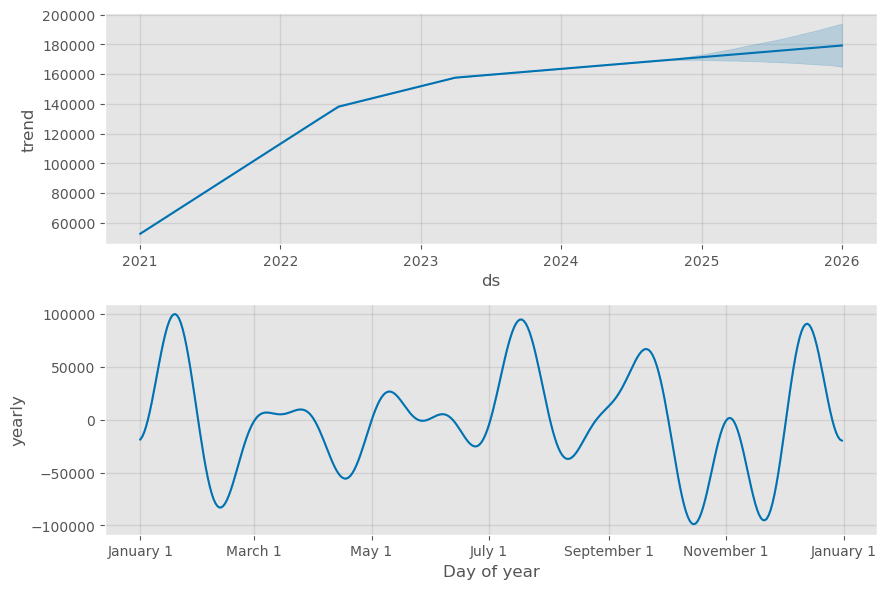

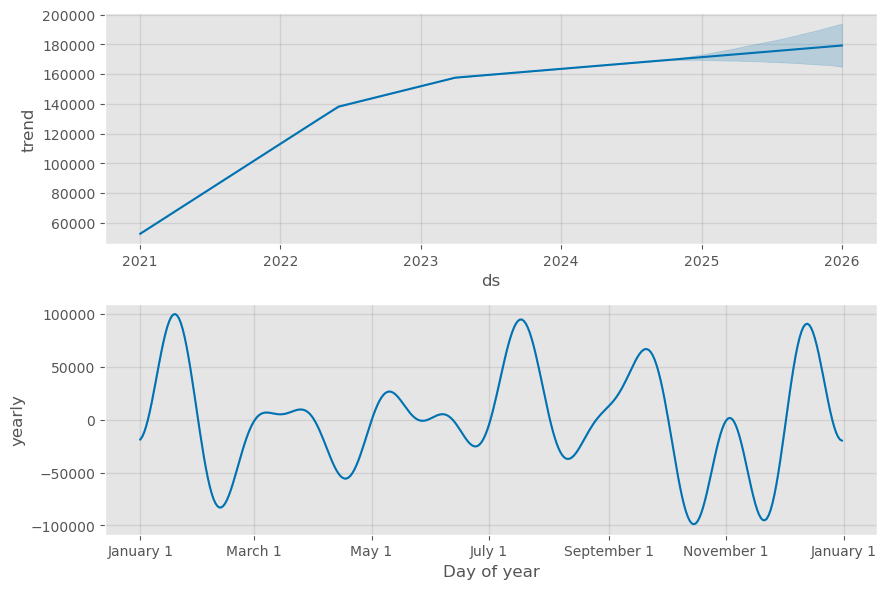

In [173]:
model_prophet.plot_components(forecast_prophet)

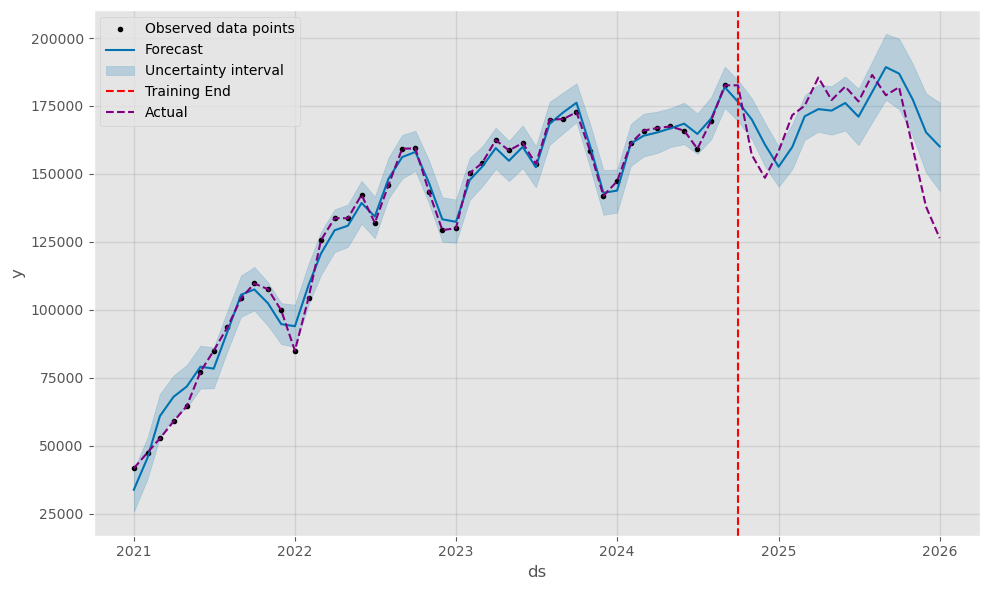

In [174]:
forecast_plot = model_prophet.plot(forecast_prophet)
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-n]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

plt.plot(monthly_riders['riders'], label='Actual', linestyle='--', color='purple')
plt.legend();

In [175]:
forecast_test = forecast_prophet[-n:][['ds', 'yhat']].set_index(['ds'])
forecast_test.head()

,yhat
ds,
2024-10-01,176524.938224
2024-11-01,170080.330955
2024-12-01,160796.693811
2025-01-01,152652.921784
2025-02-01,159923.533453


In [176]:
mse = mean_squared_error(test, forecast_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast_test)
print(f'RMSE = {rmse},\nMAPE = {mape}')

RMSE = 13995.379799417407,
MAPE = 0.07314940942578939


In [177]:
# Prophet can only be fit once - cannot be refitted
# However, we can warm stat using fit on training data to speed up Prophet refitting process
# Closest thing to refitting with ARIMA/SARIMA(X) models
# Below function from: https://facebook.github.io/prophet/docs/additional_topics.html#updating-fitted-models

def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialize a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

In [178]:
full_model_proph = Prophet(interval_width=0.95)
full_model_proph.fit(mrid, init=warm_start_params(model_prophet))

01:27:43 - cmdstanpy - INFO - Chain [1] start processing
01:27:44 - cmdstanpy - INFO - Chain [1] done processing


In [179]:
df_pred = full_model_proph.make_future_dataframe(periods=28, freq='MS')
forecast_prophet = full_model_proph.predict(df_pred)
forecast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,53000.129686,20490.556124,45381.970033,53000.129686,53000.129686,-19781.996568,-19781.996568,-19781.996568,-19781.996568,-19781.996568,-19781.996568,0.0,0.0,0.0,33218.133118
1,2021-02-01,57876.140233,40294.225416,64479.325559,57876.140233,57876.140233,-5602.473640,-5602.473640,-5602.473640,-5602.473640,-5602.473640,-5602.473640,0.0,0.0,0.0,52273.666593
2,2021-03-01,62280.278791,51718.442628,74698.927205,62280.278791,62280.278791,712.460934,712.460934,712.460934,712.460934,712.460934,712.460934,0.0,0.0,0.0,62992.739725
3,2021-04-01,67156.289343,59327.850227,84307.027208,67156.289343,67156.289343,4667.253398,4667.253398,4667.253398,4667.253398,4667.253398,4667.253398,0.0,0.0,0.0,71823.542740
4,2021-05-01,71875.009231,61872.483453,86019.140187,71875.009231,71875.009231,1889.441038,1889.441038,1889.441038,1889.441038,1889.441038,1889.441038,0.0,0.0,0.0,73764.450269


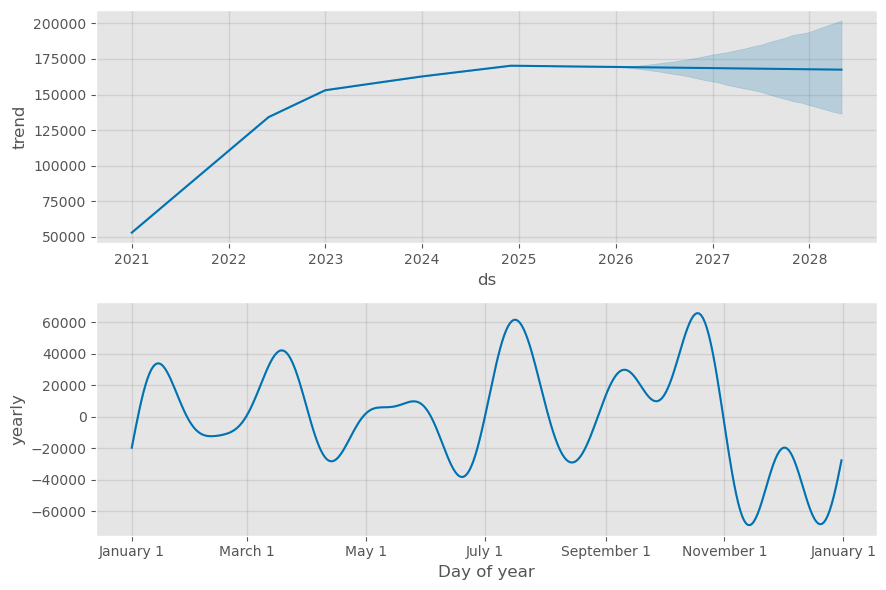

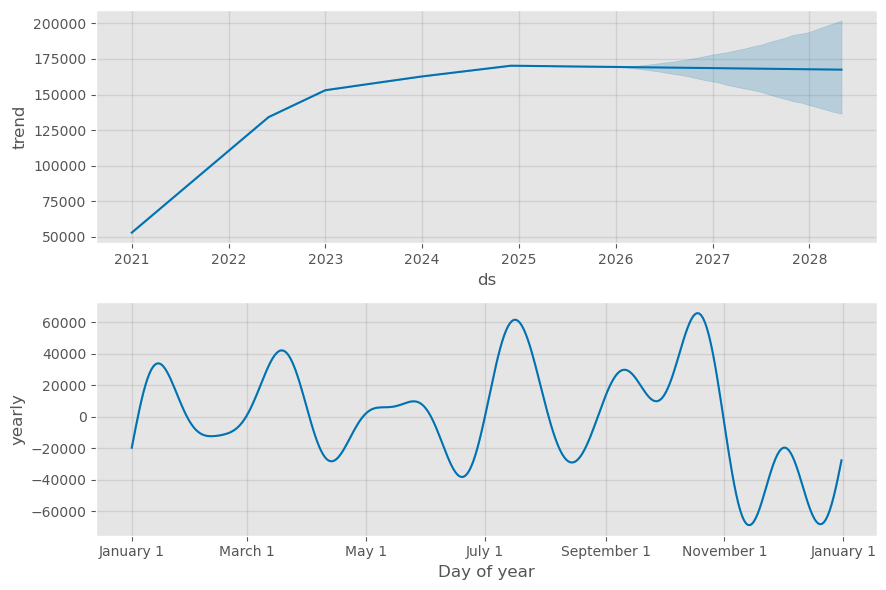

In [180]:
full_model_proph.plot_components(forecast_prophet)

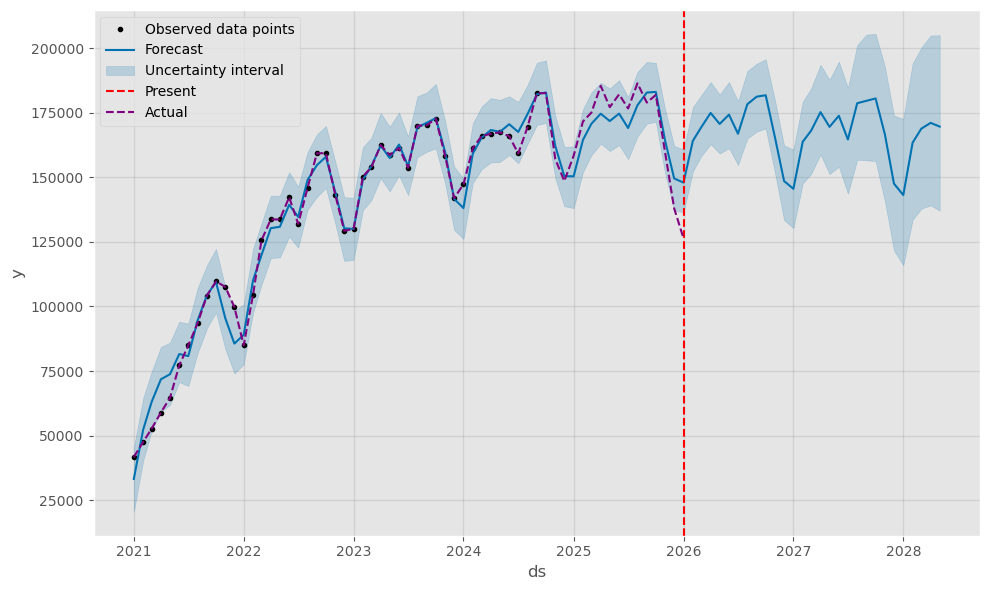

In [181]:
forecast_plot = model_prophet.plot(forecast_prophet)
axes = forecast_plot.gca()
last_date = mrid['ds'].values[-1]
axes.axvline(x=last_date, color='red', linestyle='--', label='Present')

plt.plot(monthly_riders['riders'], label='Actual', linestyle='--', color='purple')
plt.legend();

In [182]:
latest_month = pd.to_datetime('2026-01-01')

In [183]:
fcast_proph = forecast_prophet[forecast_prophet['ds'] > latest_month].set_index('ds')
fcast_proph.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2026-02-01,169306.820770,152276.466911,177161.018587,169092.149756,169537.789825,-5163.805580,-5163.805580,-5163.805580,-5163.805580,-5163.805580,-5163.805580,0.0,0.0,0.0,164143.015189
2026-03-01,169244.592068,158237.795751,181774.894722,168568.195377,169947.996843,188.045467,188.045467,188.045467,188.045467,188.045467,188.045467,0.0,0.0,0.0,169432.637536
2026-04-01,169175.696006,162873.135017,186902.934956,167980.997803,170440.322628,5778.267231,5778.267231,5778.267231,5778.267231,5778.267231,5778.267231,0.0,0.0,0.0,174953.963237
2026-05-01,169109.022397,159234.697966,182092.591897,167228.906330,171052.914064,1584.657014,1584.657014,1584.657014,1584.657014,1584.657014,1584.657014,0.0,0.0,0.0,170693.679411
2026-06-01,169040.126335,161296.136974,186924.221170,166484.145079,171732.679067,5248.807922,5248.807922,5248.807922,5248.807922,5248.807922,5248.807922,0.0,0.0,0.0,174288.934257


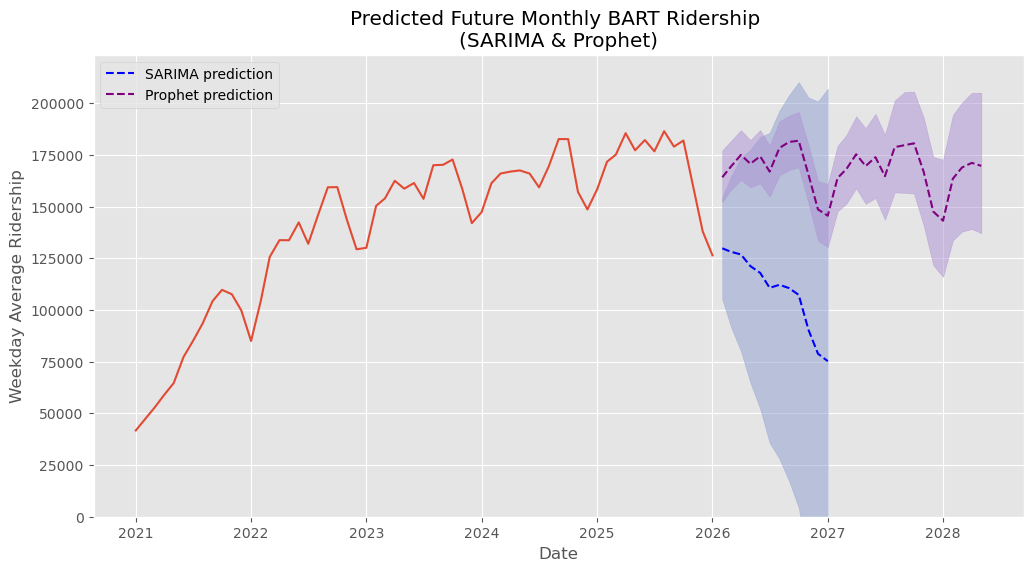

In [184]:
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_riders['riders'],
)
plt.plot(
    pred, label='SARIMA prediction', color='blue', linestyle='--'
)
plt.plot(
    fcast_proph['yhat'], label='Prophet prediction', color='purple', linestyle='--'
)
plt.fill_between(
    pred.index,
    ci[:, 0],
    ci[:, 1],
    color='#8e9ed1', alpha=0.5
)
plt.fill_between(
    fcast_proph.index,
    fcast_proph['yhat_lower'],
    fcast_proph['yhat_upper'],
    color='#ad90d4', alpha=0.5
)
plt.xlabel('Date')
plt.ylabel('Weekday Average Ridership')
plt.title('Predicted Future Monthly BART Ridership \n(SARIMA & Prophet)')
plt.ylim(bottom=0)
# plt.xlim(right=pd.to_datetime('2028-03-01'))
plt.legend();